In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
experimentdir1 = rd.datadir/'flow'/'2025.03.24_phospho-Ngn2_reprogramming'
experimentdir2 = rd.datadir/'flow'/'2025.04.14_phospho-Ngn2_reprogramming'
experimentdir3 = rd.datadir/'flow'/'2025.05.12_phospho-Ngn2_reprogramming'

outputdir = rd.rootdir/'figures'/'Ngn2_reprogramming'

In [3]:
#rd.plot.plot_well_metadata(experimentdir1/'metadata.yaml')


# Load Data

In [3]:
data_columns = ['GFP-A']

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_14dpi_A',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_14dpi_B',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_14dpi_C',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df4 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_14dpi_D',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df5 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_14dpi_E',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df6 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_14dpi',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)

df1['rep'] = 'A'
df2['rep'] = 'B'
df3['rep'] = 'C'
df4['rep'] = 'D'
df5['rep'] = 'E'

df = pd.concat([df1,df2,df3,df4,df5,df6])

In [5]:
df['condition'] = df['Ngn2'] + ' ' + df['infection'] + ' ' + df['small molecule']
df['condition2'] = df['infection'] + ', ' + df['small molecule']

Get rid of negative values

In [6]:
for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]
    

# iMN gate

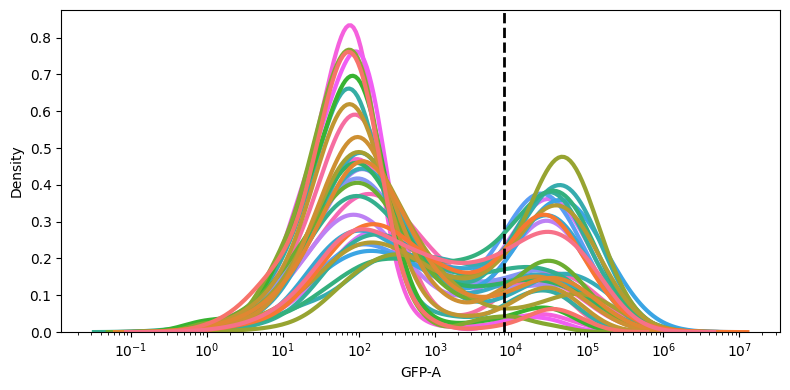

In [24]:
GFP_gate = 8 * 10**3 # Set gate at 8 * 10^3


# #Plot gate
fig=plt.figure(figsize=(8,4))
sns.kdeplot(data=df.sample(10000),x='GFP-A',hue='condition',log_scale=True,common_norm=False,linewidth=3,legend=False)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)
#fig.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


In [8]:
groups = ['rep','Ngn2','infection','small molecule','condition','condition2','well'] # 'rep' must be first group!!!!


summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > GFP_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Total Cell Count')
    ], axis=1)
summary_df = summary_df.reset_index()

# Statistics you would like to plot later
data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Total Cell Count']

# Plotting Functions

In [9]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,
                   xlabel_rot=90,xlabel='',plottitle='',palette='viridis',
                   order=None,hue_order=None,pairs=None,alpha=0.8,reps=None,hlines=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X','*']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    if hlines:
        for h in hlines:
            plt.axhline(y=h, color='#cccccc', linestyle='--',zorder=-1)

    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)



def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
        color = '#000000'
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    #sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4]):
    plt.figure(figsize=(8,4))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=False,hue_order=order,palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)

    sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.xlim(xlim)
    plt.title('4 dpi')
    plt.xlabel(xcat)
    plt.tight_layout()
    #g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)


# Plot Results

In [10]:
sns.set_theme(style="ticks",font_scale=1)

reps2plot = ['A', 'B','C','D','E','F','G']
dataslice = summary_df[summary_df['rep'].isin(reps2plot)]
palette = {'9SA.Ngn2':'firebrick',
           '9SA.Ngn2.x3HA':'coral',
           'WT.Ngn2':'teal',
           'WT.Ngn2.x3HA':'royalblue'}
savedict = {'(%) iMN yield\nper MEF plated':'(%) iMN yield per MEF plated',
            '(%) iMN\nof all cells':'(%) iMN of all cells',
            'Total Cell Count':'Total Cell Count'}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL, PMA_WT.Ngn2.x3HA vs. NIL, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.314e-04 t=4.232e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.439e-02 t=2.559e+00
NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.679e-07 t=5.943e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.743e-12 t=1.004e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL, PMA_WT.Ngn2.x3HA vs. NIL, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:2.614e-09 t=-7.619e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:2

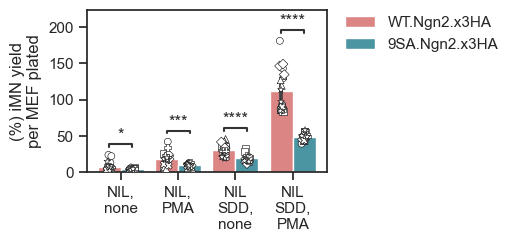

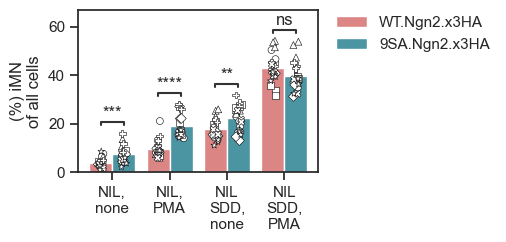

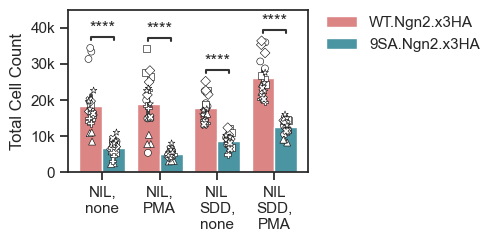

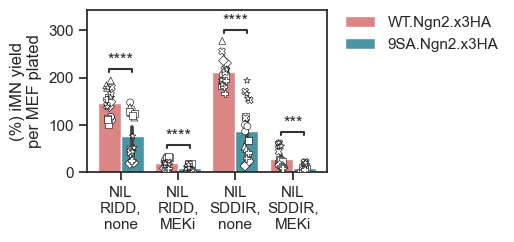

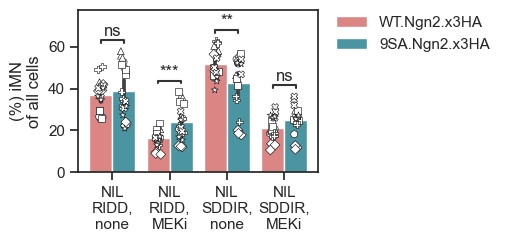

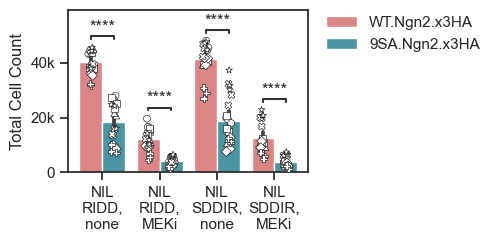

In [18]:
palette = {'WT.Ngn2.x3HA':'#ea7676','9SA.Ngn2.x3HA':'#3d9eb0'}

order = ['NIL, none','NIL, PMA',
         'NIL SDD, none','NIL SDD, PMA']

pairs = [(('NIL, none','WT.Ngn2.x3HA'),('NIL, none','9SA.Ngn2.x3HA')),
         (('NIL, PMA','WT.Ngn2.x3HA'),('NIL, PMA','9SA.Ngn2.x3HA')),
         (('NIL SDD, none','WT.Ngn2.x3HA'),('NIL SDD, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, PMA','WT.Ngn2.x3HA'),('NIL SDD, PMA','9SA.Ngn2.x3HA'))]
for i in data2plot:
    savetitle = savedict[i] + '_Ngn2x3HA_PMA'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=3.2,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs)


order = ['NIL RIDD, none', 'NIL RIDD, MEKi',
         'NIL SDDIR, none','NIL SDDIR, MEKi']

pairs = [(('NIL RIDD, none','WT.Ngn2.x3HA'),('NIL RIDD, none','9SA.Ngn2.x3HA')),
         (('NIL RIDD, MEKi','WT.Ngn2.x3HA'),('NIL RIDD, MEKi','9SA.Ngn2.x3HA')),
         (('NIL SDDIR, none','WT.Ngn2.x3HA'),('NIL SDDIR, none','9SA.Ngn2.x3HA')),
         (('NIL SDDIR, MEKi','WT.Ngn2.x3HA'),('NIL SDDIR, MEKi','9SA.Ngn2.x3HA'))]
for i in data2plot:
    savetitle = savedict[i] + '_Ngn2x3HA_MEKi'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=3.2,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs)

## Select results

In [ ]:
palette = {'WT.Ngn2.x3HA':'#ea7676','9SA.Ngn2.x3HA':'#3d9eb0'}

order = ['NIL, none',
         'NIL SDD, none','NIL SDD, PMA',
         'NIL RIDD, none', 'NIL RIDD, MEKi',]


pairs = [(('NIL, none','WT.Ngn2.x3HA'),('NIL, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, none','WT.Ngn2.x3HA'),('NIL SDD, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, PMA','WT.Ngn2.x3HA'),('NIL SDD, PMA','9SA.Ngn2.x3HA')),
         (('NIL RIDD, none','WT.Ngn2.x3HA'),('NIL RIDD, none','9SA.Ngn2.x3HA')),
         (('NIL RIDD, MEKi','WT.Ngn2.x3HA'),('NIL RIDD, MEKi','9SA.Ngn2.x3HA')),]
for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = savedict[i] + '_Ngn2x3HA'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=5,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.679e-07 t=5.943e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.439e-02 t=2.559e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.743e-12 t=1.004e+01
NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.263e-06 t=5.721e+00
NIL RIDD, MEKi_WT.Ngn2.x3HA vs. NIL RIDD, MEKi_9SA.Ngn2.x3HA: t-test independent samples, P_val:4.704e-05 t=4.563e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-te

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.679e-07 t=5.943e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.439e-02 t=2.559e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.743e-12 t=1.004e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:2.567e-03 t=-3.217e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:2.594e-04 t=-4.008e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independe

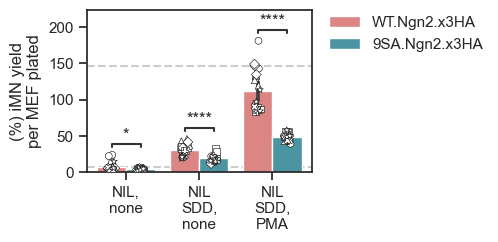

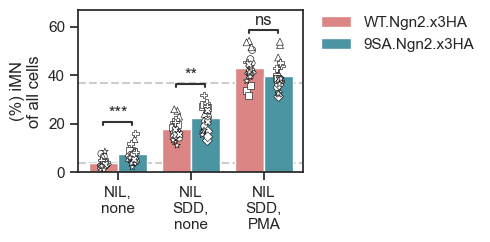

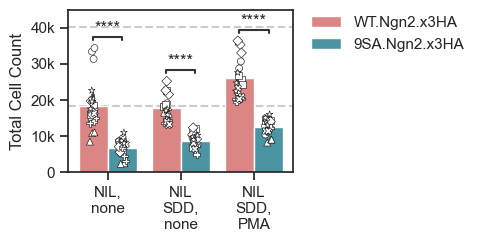

In [20]:
order = ['NIL, none',
         'NIL SDD, none','NIL SDD, PMA']


pairs = [(('NIL, none','WT.Ngn2.x3HA'),('NIL, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, none','WT.Ngn2.x3HA'),('NIL SDD, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, PMA','WT.Ngn2.x3HA'),('NIL SDD, PMA','9SA.Ngn2.x3HA'))]
for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = savedict[i] + '_Ngn2x3HA_PMA'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.263e-06 t=5.721e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.151e-01 t=-6.569e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.209e-14 t=1.142e+01


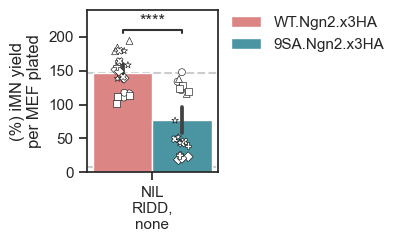

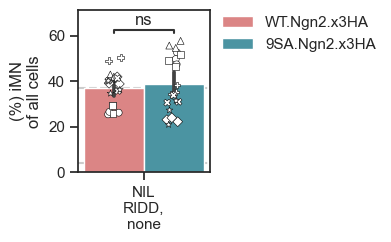

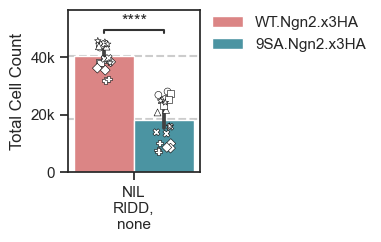

In [21]:
palette = {'WT.Ngn2.x3HA':'#ea7676','9SA.Ngn2.x3HA':'#3d9eb0'}

order = ['NIL RIDD, none']


pairs = [(('NIL RIDD, none','WT.Ngn2.x3HA'),('NIL RIDD, none','9SA.Ngn2.x3HA'))]
for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = 'RIDD-only_' + savedict[i] + '_Ngn2x3HA_PMA'
    custom_barplot('condition2',i,dataslice[dataslice.condition2.isin(order)],savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=1.75,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])
